In [124]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
housingFilePath = r'./housing_data.xlsx'
popFilePath = r'./population_data.csv'
immiFilePath = r'./immigration_data.csv'
rateFilePath = r'./interestrate_data.csv'

In [128]:
# Load housing data
housing = pd.read_excel(housingFilePath, sheet_name="Aggregate")

# Convert 'Date' to datetime
housing['Date'] = pd.to_datetime(housing['Date'], format='%b %Y')

# Optional: set Date as index
housing.set_index('Date', inplace=True)
housing.head()

,Composite_HPI,Single_Family_HPI,One_Storey_HPI,Two_Storey_HPI,Townhouse_HPI,Apartment_HPI,Composite_Benchmark,Single_Family_Benchmark,One_Storey_Benchmark,Two_Storey_Benchmark,Townhouse_Benchmark,Apartment_Benchmark
Date,,,,,,,,,,,,
2005-01-01,100.0,100.0,100.0,100.0,100.0,100.0,236400,256600,204100,299000,198800,169900
2005-02-01,101.0,101.0,101.2,100.9,100.9,101.2,238800,259200,206600,301600,200600,172000
2005-03-01,102.1,102.1,102.4,101.9,101.7,102.2,241300,262000,209100,304700,202100,173700
2005-04-01,103.1,103.2,103.8,102.9,102.4,103.1,243800,264900,211800,307600,203600,175100
2005-05-01,103.8,103.9,104.7,103.3,103.2,104.1,245400,266500,213600,309000,205100,176800


In [130]:
# Load immigration data
immigration = pd.read_csv(immiFilePath)

# Filter only for Canada and component = 'Immigrants' (if you want total immigration)
immigration = immigration[(immigration['GEO'] == 'Canada') & (immigration['Components of population growth'] == 'Immigrants')]

# Convert REF_DATE to datetime (you can choose July as mid-point for year)
immigration['Date'] = pd.to_datetime(immigration['REF_DATE'].str[:4] + '-07-01')

# Keep only needed columns
immigration = immigration[['Date', 'VALUE']]
immigration.rename(columns={'VALUE': 'Immigrants'}, inplace=True)
immigration.head()

,Date,Immigrants
48,2000-07-01,252527.0
49,2001-07-01,256405.0
50,2002-07-01,199170.0
51,2003-07-01,239101.0
52,2004-07-01,244599.0


In [132]:
# Load population data
population = pd.read_csv(popFilePath)

# Filter for Canada
population = population[population['GEO'] == 'Canada']

# Convert REF_DATE to datetime
population['Date'] = pd.to_datetime(population['REF_DATE'], format='%Y-%m')

# Keep only relevant column
population = population[['Date', 'VALUE']]
population.rename(columns={'VALUE': 'Population'}, inplace=True)
population.head()

,Date,Population
0,2000-01-01,30525872
1,2000-04-01,30594030
2,2000-07-01,30685730
3,2000-10-01,30783969
4,2001-01-01,30824441


In [162]:
# Load Interest Rate data
rate = pd.read_csv(rateFilePath)

# Filter for Canada
rate = rate[rate['GEO'] == 'Canada']

rate['Date'] = pd.to_datetime(rate['REF_DATE'],format='%d-%m-%Y')

# Keep only relevant column
rate = rate[['Date', 'VALUE']]
rate.rename(columns={'VALUE':'Interest_Rate'}, inplace=True)

In [184]:
# Merge on 'Date' using outer join (to keep all time points)
merged = housing.reset_index().merge(population, on='Date', how='left')
merged2 = merged.merge(rate, on='Date', how='left')
merged = merged2.merge(immigration, on='Date', how='left')

# For interest rate, using forward fill to fill any missing values
merged['Interest_Rate'] = merged['Interest_Rate'].ffill()

# Only drop rows missing key information
merged.dropna(subset=['Composite_HPI','Composite_Benchmark', 'Population', 'Immigrants', 'Interest_Rate'], inplace=True)

# Remove duplicates based on date
merged = merged.drop_duplicates(subset='Date', keep='first')

merged.head()

,index,Date,Composite_HPI,Single_Family_HPI,One_Storey_HPI,Two_Storey_HPI,Townhouse_HPI,Apartment_HPI,Composite_Benchmark,Single_Family_Benchmark,One_Storey_Benchmark,Two_Storey_Benchmark,Townhouse_Benchmark,Apartment_Benchmark,Province,Population,Interest_Rate,Immigrants
24,6,2005-07-01,104.5,104.6,107.0,102.2,100.4,100.0,134100,134400,119300,155500,130000.0,106800.0,Newfoundland and Labrador,514310.0,2.25,4525.0
116,18,2006-07-01,107.4,107.6,111.3,103.9,91.2,101.0,137800,138300,124100,158100,118100.0,107900.0,Newfoundland and Labrador,510593.0,4.25,4500.0
208,30,2007-07-01,112.3,112.3,116.1,108.5,117.2,102.3,144100,144300,129400,165200,151800.0,109300.0,Newfoundland and Labrador,509047.0,4.25,4661.0
300,42,2008-07-01,134.1,134.3,139.6,129.2,129.9,127.2,172100,172600,155700,196700,168200.0,135800.0,Newfoundland and Labrador,511569.0,2.75,4926.0
392,54,2009-07-01,152.4,152.7,158.7,147.8,145.9,142.7,195500,196200,176900,225000,188900.0,152400.0,Newfoundland and Labrador,516741.0,0.25,4946.0


In [186]:
# Choose numeric columns only
numeric_data = merged.select_dtypes(include='number')

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# correlation with Composite_Benchmark
print(correlation_matrix['Composite_Benchmark'].sort_values(ascending=False))

Composite_Benchmark        1.000000
Composite_HPI              1.000000
Single_Family_Benchmark    0.999982
Single_Family_HPI          0.999981
One_Storey_Benchmark       0.999542
One_Storey_HPI             0.999535
Two_Storey_Benchmark       0.998539
Two_Storey_HPI             0.998537
Apartment_Benchmark        0.984869
Apartment_HPI              0.984821
Townhouse_Benchmark        0.976397
Townhouse_HPI              0.976390
Population                 0.943286
index                      0.821411
Interest_Rate             -0.487455
Immigrants                -0.558376
Name: Composite_Benchmark, dtype: float64


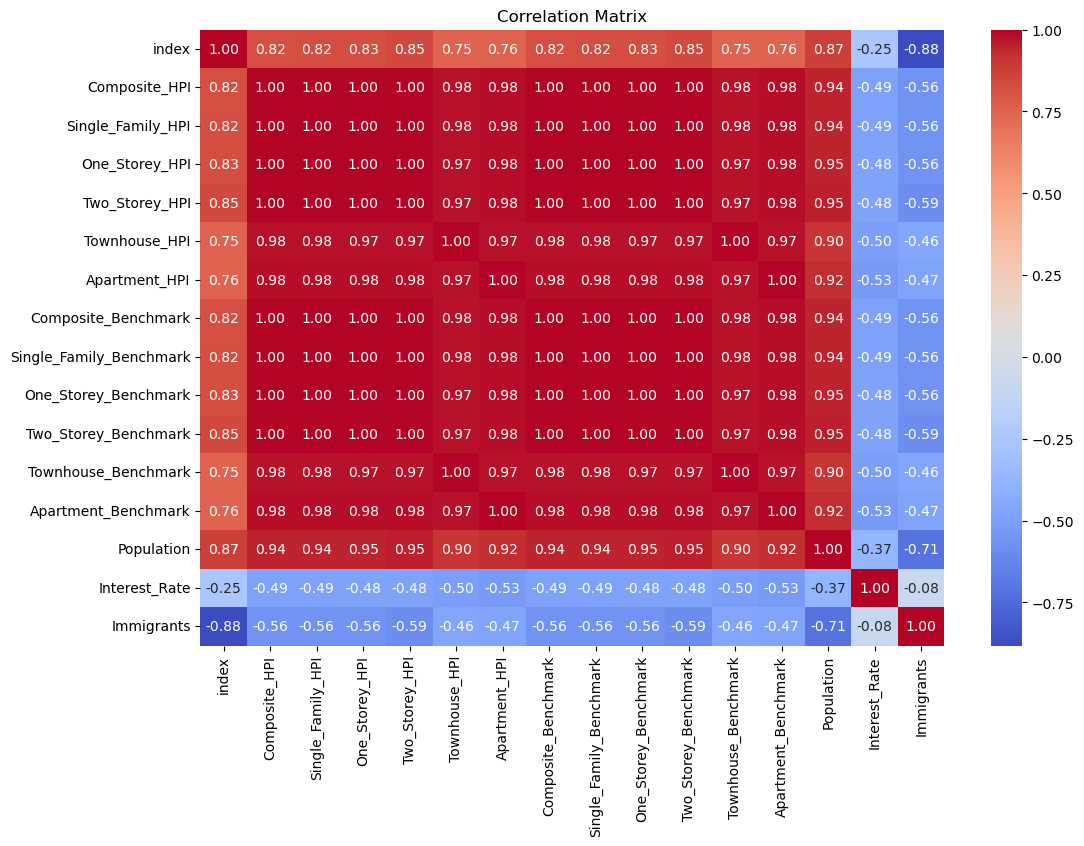

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

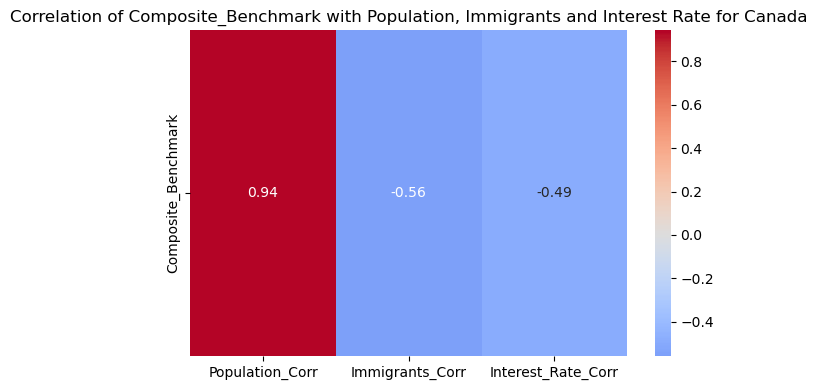

In [211]:
can_comparison_rows = []

canada_corr = correlation_matrix['Composite_Benchmark'].loc[['Population', 'Immigrants', 'Interest_Rate']]

# Create DataFrame from collected rows
canada_comparison_df = pd.DataFrame(canada_corr).T
canada_comparison_df.rename(columns={
    'Population': 'Population_Corr',
    'Immigrants': 'Immigrants_Corr',
    'Interest_Rate': 'Interest_Rate_Corr'
}, inplace=True)

# Plot a heatmap for Canada aggregate correlation results
plt.figure(figsize=(6, 4))
sns.heatmap(canada_comparison_df, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Composite_Benchmark with Population, Immigrants and Interest Rate for Canada')
plt.tight_layout()
plt.show()

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings

# -------------------------------
# Assume 'merged' DataFrame exists with columns:
# 'Composite_HPI', 'Population', 'Immigrants', 'Interest_Rate', 'Composite_Benchmark'
# Forward fill missing Interest_Rate if necessary
merged['Interest_Rate'] = merged['Interest_Rate'].ffill()

# -------------------------------
# Select features and target
# Here we predict Composite_Benchmark (the dollar benchmark price)
X = merged[['Composite_HPI', 'Population', 'Immigrants', 'Interest_Rate']]
y = merged['Composite_Benchmark']

# -------------------------------
# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# Initialize regression models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),   # You can adjust alpha as needed
    "Lasso Regression": Lasso(alpha=0.1)      # Adjust alpha as needed
}

# Define 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    # Fit the model on training data
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate test set metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Cross-validation: using complete dataset X and y
    cv_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2')
    cv_mae = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    cv_mse = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(cv_mse)
    
    results[name] = {
        "Test MAE": mae,
        "Test R2": r2,
        "Test RMSE": rmse,
        "CV Mean R2": np.mean(cv_r2),
        "CV Mean MAE": np.mean(cv_mae),
        "CV Mean RMSE": np.mean(cv_rmse)
    }
    
    print(f"{name}:")
    print(f"    Test Set Metrics -> MAE: {mae:.2f}, R²: {r2:.2f}, RMSE: {rmse:.2f}")
    print(f"    Cross-Validation Mean Metrics -> MAE: {np.mean(cv_mae):.2f}, R²: {np.mean(cv_r2):.2f}, RMSE: {np.mean(cv_rmse):.2f}")
    print()

# -------------------------------
print("Example predictions (using Linear Regression):")
for i in range(3):
    pred_lin = models["Linear Regression"].predict(X_test.iloc[i:i+1])[0]
    actual = y_test.iloc[i]
    print(f"Sample {i+1}: Predicted = {pred_lin:.2f}, Actual = {actual:.2f}")

print("\nExample predictions (using Ridge Regression):")
for i in range(3):
    pred_ridge = models["Ridge Regression"].predict(X_test.iloc[i:i+1])[0]
    actual = y_test.iloc[i]
    print(f"Sample {i+1}: Predicted = {pred_ridge:.2f}, Actual = {actual:.2f}")

print("\nExample predictions (using Lasso Regression):")
for i in range(3):
    pred_lasso = models["Lasso Regression"].predict(X_test.iloc[i:i+1])[0]
    actual = y_test.iloc[i]
    print(f"Sample {i+1}: Predicted = {pred_lasso:.2f}, Actual = {actual:.2f}")

Linear Regression:
    Test Set Metrics -> MAE: 53.78, R²: 1.00, RMSE: 61.64
    Cross-Validation Mean Metrics -> MAE: 42.74, R²: 1.00, RMSE: 48.66

Ridge Regression:
    Test Set Metrics -> MAE: 40.22, R²: 1.00, RMSE: 46.36
    Cross-Validation Mean Metrics -> MAE: 42.26, R²: 1.00, RMSE: 46.55

Lasso Regression:
    Test Set Metrics -> MAE: 35.02, R²: 1.00, RMSE: 41.58
    Cross-Validation Mean Metrics -> MAE: 39.63, R²: 1.00, RMSE: 44.53

Example predictions (using Linear Regression):
Sample 1: Predicted = 134032.33, Actual = 134100.00
Sample 2: Predicted = 225656.89, Actual = 225700.00
Sample 3: Predicted = 254107.11, Actual = 254200.00

Example predictions (using Ridge Regression):
Sample 1: Predicted = 134082.19, Actual = 134100.00
Sample 2: Predicted = 225661.87, Actual = 225700.00
Sample 3: Predicted = 254121.84, Actual = 254200.00

Example predictions (using Lasso Regression):
Sample 1: Predicted = 134105.31, Actual = 134100.00
Sample 2: Predicted = 225665.18, Actual = 225700.0

In [144]:
# Now lets do, Correlation Analysis for all Canada Provinces
known_provinces = {
    'British_Columbia', 'Alberta', 'Saskatchewan', 'Winnipeg',
    'Ontario', 'Quebec', 'New_Brunswick', 'Nova_Scotia',
    'Prince_Edward_Island', 'Newfoundland_and_Labrador'
} # Since, Manitoba data is missing, considering, Winnipeg data for Manitoba as a whole. 

province_map = {
    'Winnipeg': 'Manitoba',
    'Newfoundland_and_Labrador': 'Newfoundland and Labrador',
    'Prince_Edward_Island': 'Prince Edward Island',
    'Nova_Scotia': 'Nova Scotia',
    'New_Brunswick': 'New Brunswick',
    'Quebec': 'Quebec',
    'Ontario': 'Ontario',
    'Manitoba': 'Manitoba',
    'Saskatchewan': 'Saskatchewan',
    'Alberta': 'Alberta',
    'British_Columbia': 'British Columbia'
}

all_dfs = []
for sheet_name in known_provinces:
    df = pd.read_excel(housingFilePath, sheet_name=sheet_name)
    df['Province'] = province_map.get(sheet_name, sheet_name)
    all_dfs.append(df)

merged_housing_df = pd.concat(all_dfs, ignore_index=True)
merged_housing_df['Province'].unique()

array(['Newfoundland and Labrador', 'Manitoba', 'Quebec',
       'British Columbia', 'New Brunswick', 'Nova Scotia',
       'Prince Edward Island', 'Ontario', 'Alberta', 'Saskatchewan'],
      dtype=object)

In [146]:
# Check GEO column of population, immigration and interest rate with Provinces names of Housing data
pop_df = pd.read_csv(popFilePath)
pop_province_unique = set(pop_df['GEO'].unique())
housing_province_unique = set(merged_housing_df['Province'].unique())


## Check if all housing province values are also on population data
if len(housing_province_unique-pop_province_unique) > 0:
    print("All 10 Provinces are not in Population Data")
else:
    print("All 10 Provinces are in Population Data")

# Immigration Data
immi_df = pd.read_csv(immiFilePath)
immi_province_unique = set(immi_df['GEO'].unique())

## Check if all housing province values are also on immigration data
if len(housing_province_unique-pop_province_unique) > 0:
    print("All 10 Provinces are not in Immigration Data")
else:
    print("All 10 Provinces are in Immigration Data")

# Rate Data
rate_df = pd.read_csv(rateFilePath)
rate_province_unique = set(rate_df['GEO'].unique())

# Since, Canada will have one interest rate declared by Bank of Canada 
# so, we will be using the Canada dataset for all province analysis also. 

print(rate_province_unique)


All 10 Provinces are in Population Data
All 10 Provinces are in Immigration Data
{'Canada'}


In [148]:
# Calculate Correlation for Each one of 10 provinces
provinces = [
    'British Columbia',
    'Alberta',
    'Saskatchewan',
    'Manitoba',  # Not listed in your data but should be included normally
    'Ontario',
    'Quebec',
    'New Brunswick',
    'Nova Scotia',
    'Prince Edward Island',
    'Newfoundland and Labrador'
]

results = {}

for province in provinces:
    # Filter data for the province
    housing = merged_housing_df[merged_housing_df['Province'] == province].copy()
    population = pop_df[pop_df['GEO'] == province].copy()
    immigration = immi_df[immi_df['GEO'] == province].copy()
    rate = rate_df.copy()
    
    # Convert dates to consistent format
    housing['Date'] = pd.to_datetime(housing['Date'])
    immigration['Date'] = pd.to_datetime(immigration['REF_DATE'].str[:4] + '-07-01')
    population['Date'] = pd.to_datetime(population['REF_DATE'], format='%Y-%m')
    rate['Date'] = pd.to_datetime(rate['REF_DATE'],format='%d-%m-%Y')


    # Keep only Immigration, Population and Interest Rate Data
    immigration = immigration[['Date', 'VALUE']]
    immigration.rename(columns={'VALUE': 'Immigrants'}, inplace=True)

    population = population[['Date', 'VALUE']]
    population.rename(columns={'VALUE': 'Population'}, inplace=True)

    rate = rate[['Date','VALUE']]
    rate.rename(columns={'VALUE':'Interest_Rate'}, inplace=True)
    
    # Merge datasets on date
    merged = housing.merge(population, on='Date', how='left')
    merged = merged.merge(immigration, on='Date', how='left')
    merged = merged.merge(rate, on='Date', how='left')

    # For interest rate, using forward fill to fill any missing values
    merged['Interest_Rate'] = merged['Interest_Rate'].ffill()

    # Only drop rows missing key information
    merged.dropna(subset=['Composite_HPI', 'Composite_Benchmark', 'Population', 'Immigrants', 'Interest_Rate'], inplace=True)

    # print(merged.head())
    
    # Select only numeric columns for correlation
    numeric_cols = merged.select_dtypes(include='number')
    
    # Calculate correlation matrix
    corr = numeric_cols.corr()
    
    # Save Composite_Benchmark correlations only
    results[province] = corr['Composite_Benchmark'].sort_values(ascending=False)

# Show one example
print(results['Ontario'])

Composite_Benchmark        1.000000
Composite_HPI              1.000000
Single_Family_Benchmark    0.999821
Single_Family_HPI          0.999821
Two_Storey_HPI             0.999626
Two_Storey_Benchmark       0.999626
One_Storey_HPI             0.998829
One_Storey_Benchmark       0.998827
Townhouse_Benchmark        0.997354
Townhouse_HPI              0.997352
Apartment_HPI              0.989865
Apartment_Benchmark        0.989858
Population                 0.972594
Immigrants                 0.413729
Interest_Rate             -0.079598
Name: Composite_Benchmark, dtype: float64



Correlation for British Columbia
Composite_Benchmark        1.000000
Composite_HPI              1.000000
Single_Family_Benchmark    0.998825
Single_Family_HPI          0.998821
Two_Storey_HPI             0.996062
Two_Storey_Benchmark       0.996061
One_Storey_Benchmark       0.988750
One_Storey_HPI             0.988745
Apartment_Benchmark        0.980961
Apartment_HPI              0.980949
Townhouse_Benchmark        0.978718
Townhouse_HPI              0.978704
Population                 0.962760
Immigrants                 0.417235
Interest_Rate             -0.124406
Name: Composite_Benchmark, dtype: float64


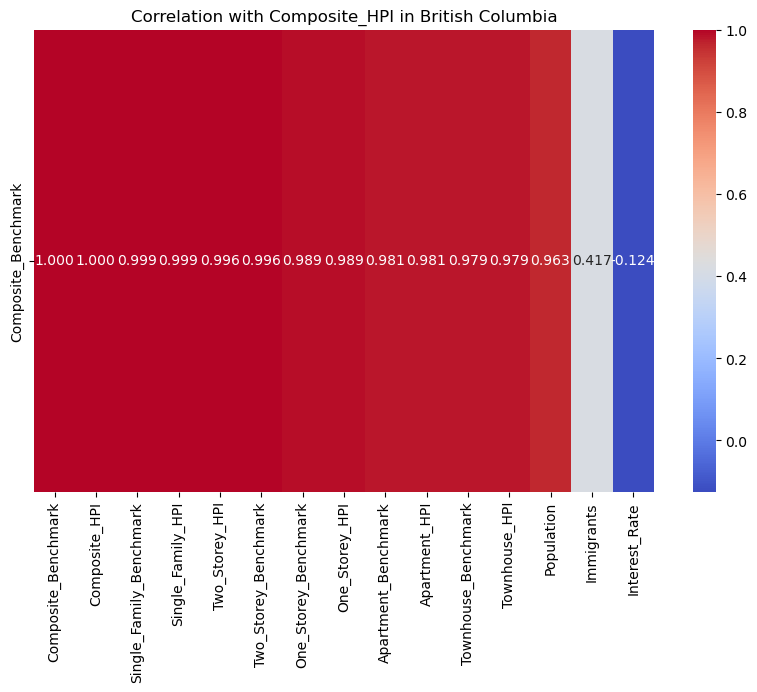


Correlation for Alberta
Composite_Benchmark        1.000000
Composite_HPI              0.999999
Single_Family_Benchmark    0.999073
Single_Family_HPI          0.999072
One_Storey_HPI             0.998758
One_Storey_Benchmark       0.998749
Two_Storey_HPI             0.996856
Two_Storey_Benchmark       0.996839
Townhouse_Benchmark        0.970967
Townhouse_HPI              0.970962
Apartment_Benchmark        0.860267
Apartment_HPI              0.860055
Population                 0.858676
Immigrants                 0.252239
Interest_Rate             -0.054687
Name: Composite_Benchmark, dtype: float64


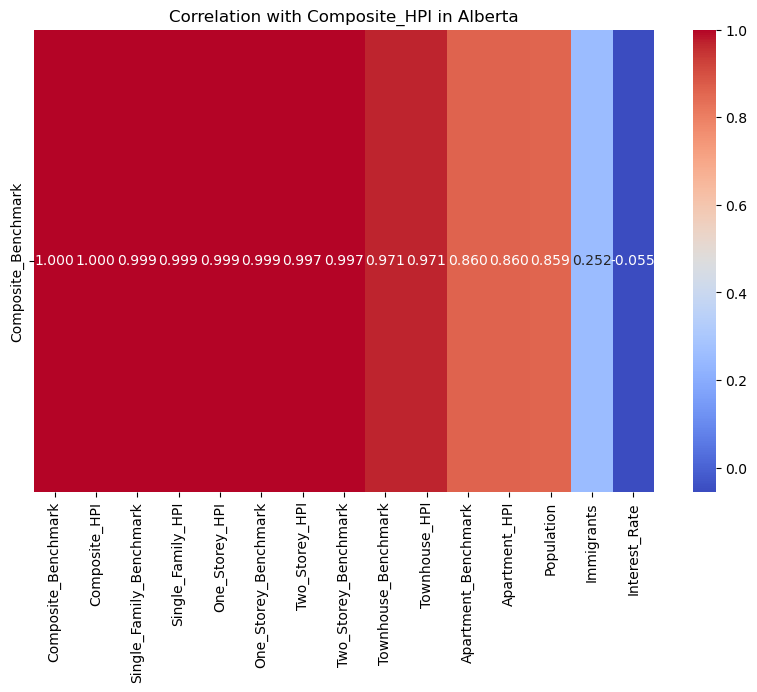


Correlation for Saskatchewan
Composite_Benchmark        1.000000
Composite_HPI              1.000000
Single_Family_Benchmark    0.998433
Single_Family_HPI          0.998420
One_Storey_HPI             0.997938
One_Storey_Benchmark       0.997935
Two_Storey_Benchmark       0.989354
Two_Storey_HPI             0.989348
Townhouse_Benchmark        0.953971
Townhouse_HPI              0.953935
Apartment_Benchmark        0.881200
Apartment_HPI              0.881181
Population                 0.873720
Immigrants                 0.156179
Interest_Rate             -0.447055
Name: Composite_Benchmark, dtype: float64


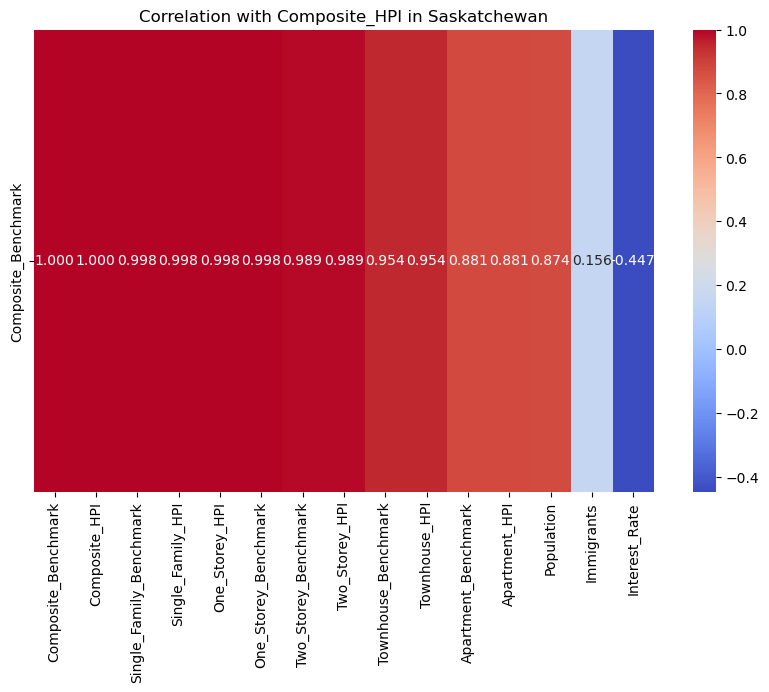


Correlation for Manitoba
Composite_Benchmark        1.000000
Composite_HPI              1.000000
One_Storey_HPI             0.999797
One_Storey_Benchmark       0.999794
Single_Family_HPI          0.999747
Single_Family_Benchmark    0.999744
Two_Storey_Benchmark       0.998604
Two_Storey_HPI             0.998602
Townhouse_HPI              0.991373
Townhouse_Benchmark        0.991357
Apartment_HPI              0.967343
Apartment_Benchmark        0.967250
Population                 0.962131
Immigrants                 0.276069
Interest_Rate             -0.296239
Name: Composite_Benchmark, dtype: float64


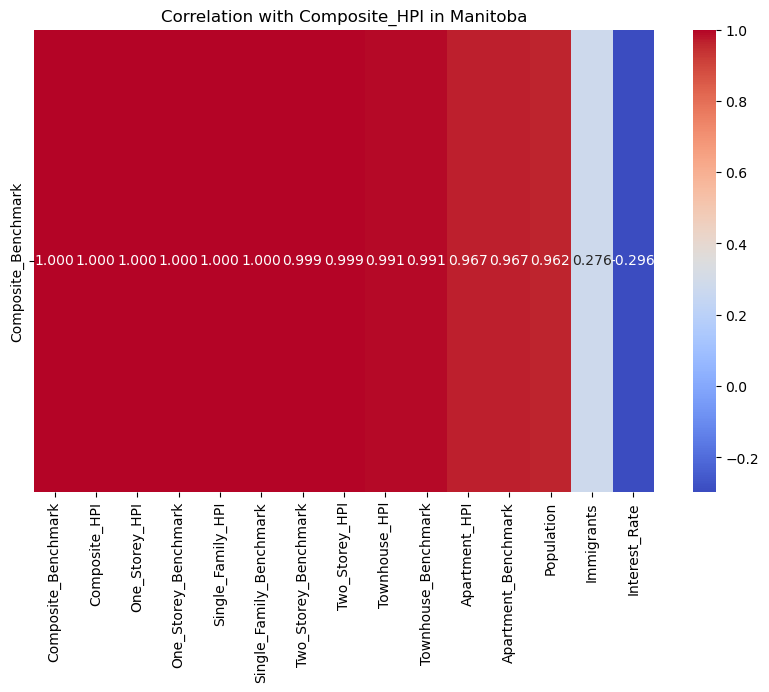


Correlation for Ontario
Composite_Benchmark        1.000000
Composite_HPI              1.000000
Single_Family_Benchmark    0.999821
Single_Family_HPI          0.999821
Two_Storey_HPI             0.999626
Two_Storey_Benchmark       0.999626
One_Storey_HPI             0.998829
One_Storey_Benchmark       0.998827
Townhouse_Benchmark        0.997354
Townhouse_HPI              0.997352
Apartment_HPI              0.989865
Apartment_Benchmark        0.989858
Population                 0.972594
Immigrants                 0.413729
Interest_Rate             -0.079598
Name: Composite_Benchmark, dtype: float64


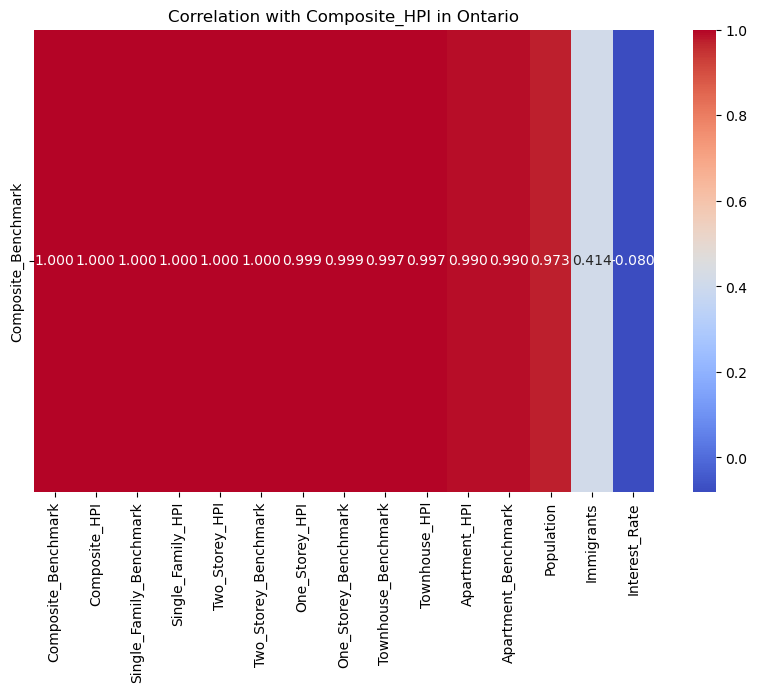


Correlation for Quebec
Composite_Benchmark        1.000000
Composite_HPI              1.000000
Two_Storey_Benchmark       0.999695
Two_Storey_HPI             0.999694
Single_Family_Benchmark    0.999556
Single_Family_HPI          0.999554
One_Storey_HPI             0.998084
One_Storey_Benchmark       0.998083
Apartment_Benchmark        0.997851
Apartment_HPI              0.997835
Townhouse_HPI              0.993975
Townhouse_Benchmark        0.993967
Population                 0.942007
Immigrants                 0.347478
Interest_Rate             -0.080420
Name: Composite_Benchmark, dtype: float64


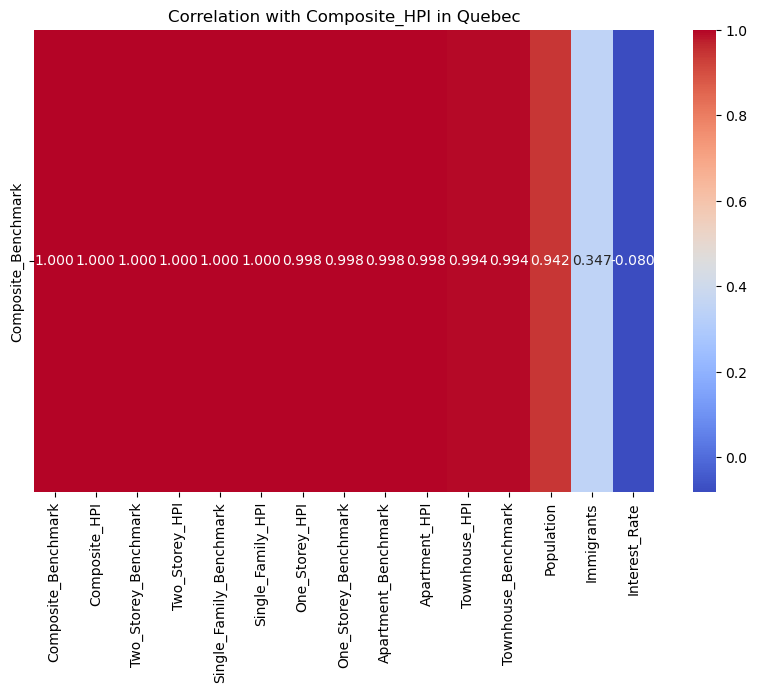


Correlation for New Brunswick
Composite_Benchmark        1.000000
Composite_HPI              1.000000
Single_Family_Benchmark    0.999991
Single_Family_HPI          0.999990
One_Storey_HPI             0.999520
One_Storey_Benchmark       0.999517
Two_Storey_HPI             0.999278
Two_Storey_Benchmark       0.999273
Apartment_Benchmark        0.978928
Apartment_HPI              0.978925
Townhouse_Benchmark        0.961615
Townhouse_HPI              0.961598
Population                 0.947206
Immigrants                 0.470388
Interest_Rate              0.065606
Name: Composite_Benchmark, dtype: float64


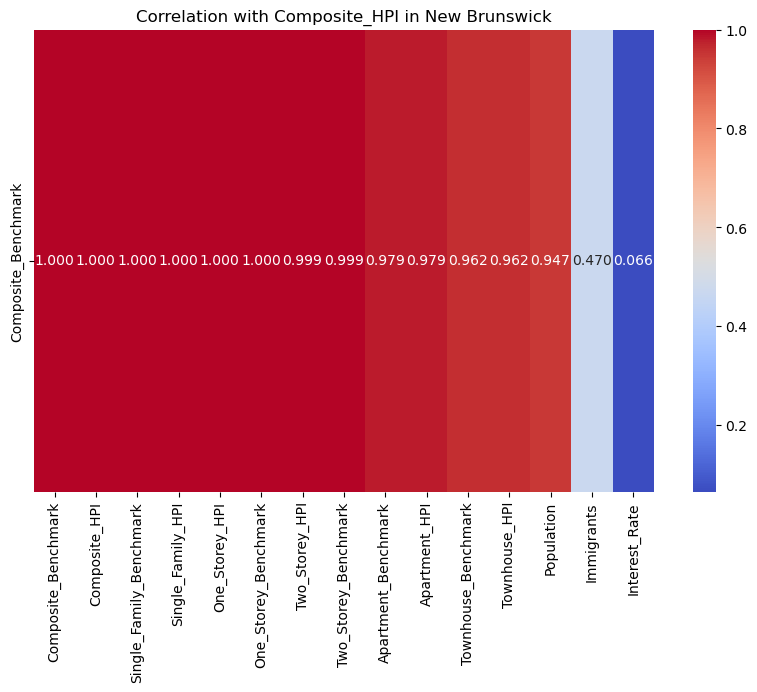


Correlation for Nova Scotia
Composite_Benchmark        1.000000
Composite_HPI              1.000000
Single_Family_Benchmark    0.999959
Single_Family_HPI          0.999958
Two_Storey_HPI             0.999395
Two_Storey_Benchmark       0.999392
One_Storey_HPI             0.998952
One_Storey_Benchmark       0.998951
Apartment_HPI              0.994953
Apartment_Benchmark        0.994952
Townhouse_Benchmark        0.993661
Townhouse_HPI              0.993655
Population                 0.960588
Immigrants                 0.466286
Interest_Rate              0.018788
Name: Composite_Benchmark, dtype: float64


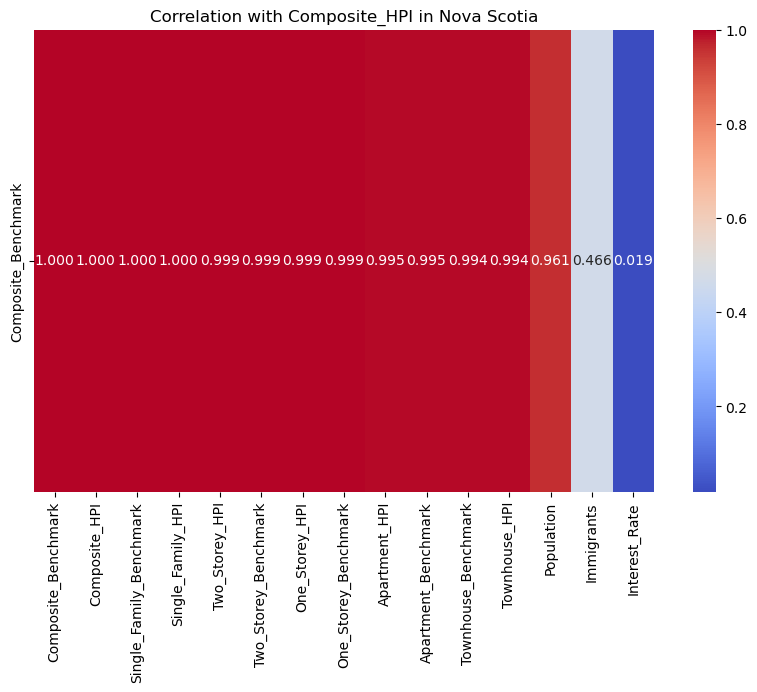


Correlation for Prince Edward Island
Composite_Benchmark        1.000000
Single_Family_Benchmark    1.000000
Composite_HPI              1.000000
Single_Family_HPI          1.000000
One_Storey_HPI             0.999482
One_Storey_Benchmark       0.999481
Two_Storey_HPI             0.999031
Two_Storey_Benchmark       0.999026
Population                 0.972143
Immigrants                 0.457440
Interest_Rate              0.024736
Townhouse_HPI                   NaN
Apartment_HPI                   NaN
Townhouse_Benchmark             NaN
Apartment_Benchmark             NaN
Name: Composite_Benchmark, dtype: float64


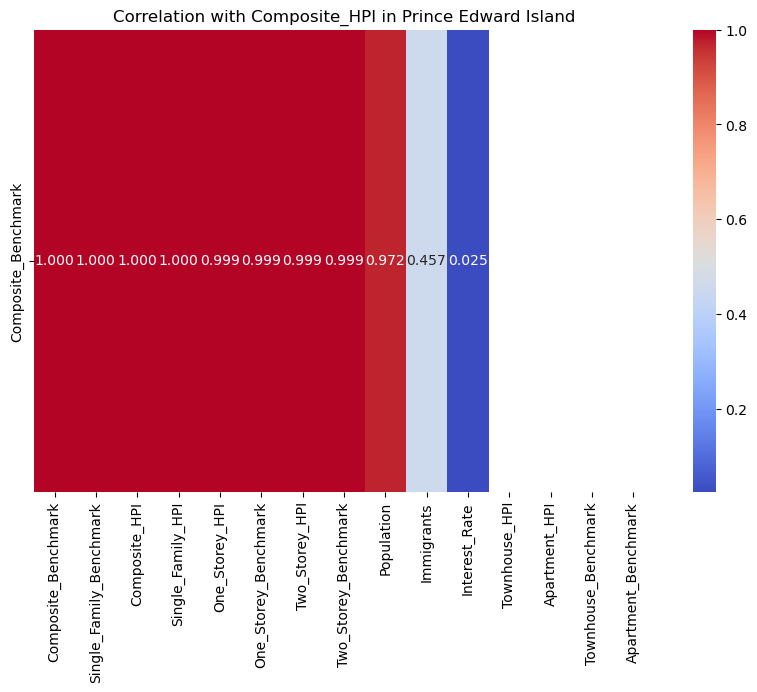


Correlation for Newfoundland and Labrador
Composite_Benchmark        1.000000
Composite_HPI              1.000000
Single_Family_Benchmark    0.999982
Single_Family_HPI          0.999981
One_Storey_Benchmark       0.999565
One_Storey_HPI             0.999558
Two_Storey_Benchmark       0.998609
Two_Storey_HPI             0.998606
Apartment_Benchmark        0.984910
Apartment_HPI              0.984861
Townhouse_Benchmark        0.976466
Townhouse_HPI              0.976461
Population                 0.943686
Immigrants                 0.173887
Interest_Rate             -0.495249
Name: Composite_Benchmark, dtype: float64


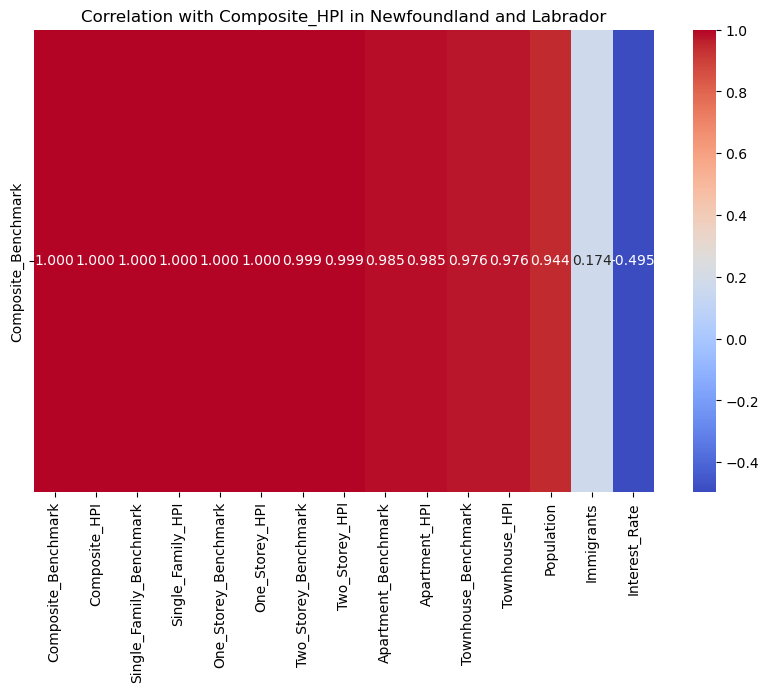

In [150]:
# Showing Seaborn Heatmap
for province in results:
    print(f"\nCorrelation for {province}")
    print(results[province])

    # Plot heatmap for this province
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        results[province].to_frame().T,
        annot=True,
        cmap='coolwarm',
        cbar=True,
        fmt=".3f"
    )
    plt.title(f"Correlation with Composite_Benchmark in {province}")
    plt.show()

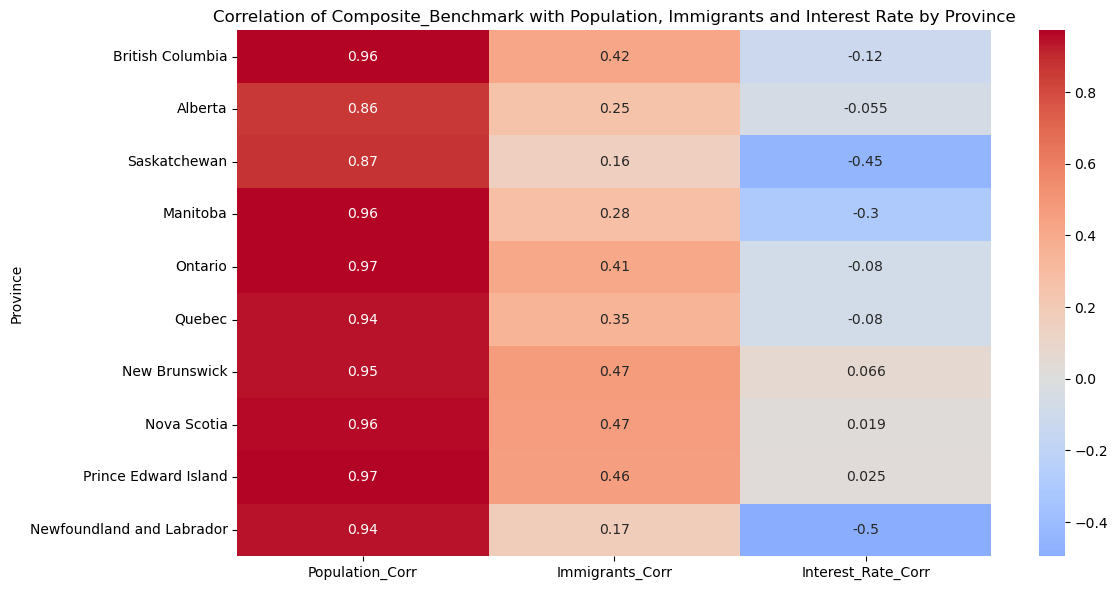

In [152]:
# Collect rows as dictionaries first
comparison_rows = []

for province, corr_series in results.items():
    population_corr = corr_series.get('Population', None)
    immigrants_corr = corr_series.get('Immigrants', None)
    rate_corr = corr_series.get('Interest_Rate', None)
    
    comparison_rows.append({
        'Province': province,
        'Population_Corr': population_corr,
        'Immigrants_Corr': immigrants_corr,
        'Interest_Rate_Corr': rate_corr
    })

# Create DataFrame from collected rows
comparison_df = pd.DataFrame(comparison_rows)

# Set Province as index
comparison_df.set_index('Province', inplace=True)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_df.astype(float), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Composite_Benchmark with Population, Immigrants and Interest Rate by Province')
plt.tight_layout()
plt.show()